In [1]:
#libraries
from time import time
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np

# import torch
from torch.utils.data import Dataset
# from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [2]:
print(torch.version.cuda)

11.0


In [3]:
img_dir = '../input/col774-2022/images/images/'
train_path_x ='../input/col774-2022/train_x.csv'
train_path_y ='../input/col774-2022/train_y.csv'
test_path_x = '../input/col774-2022/non_comp_test_x.csv'
test_path_y = '../input/col774-2022/non_comp_test_y.csv'

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, train_path_x, train_path_y, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(train_path_y)
        self.img_names  = pd.read_csv(train_path_x)
        self.img_names  = self.img_names.set_index('Id')
        self.img_labels = self.img_labels.set_index('Id')
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):        
        img_path = os.path.join(self.img_dir, self.img_names['Cover_image_name'][idx])
        image = read_image(img_path)
        image = image/255.0

        label = self.img_labels['Genre'][idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

#         device = "cuda" if torch.cuda.is_available() else "cpu"
#         image.to(device), label
        return image, label

In [5]:
training_data = CustomImageDataset(train_path_x, train_path_y, img_dir)
test_data = CustomImageDataset(test_path_x, test_path_y, img_dir)
train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=100, shuffle=True)
#try dataloader on cuda

<class 'torch.Tensor'>


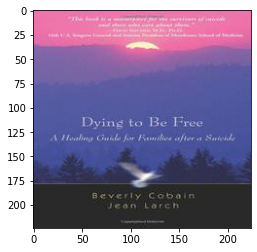

Label: 10


In [6]:
#ignore exp..
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# print(train_features[0].squeeze())
# print(train_labels[9])
print(type(train_features[0]))
img = train_features[0].squeeze()

label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(32, 64, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(64, 128, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Flatten(),
            nn.Linear(128*24*24, 128),
            nn.ReLU(),
            nn.Linear(128, 30)            
        )
        
    def forward(self, x):
        return self.network(x)        

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)
print(device)

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=73728, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=30, bias=True)
  )
)
cuda


In [9]:
learning_rate = 0.1 #1e-2
loss_fn = nn.CrossEntropyLoss()#torch.nn
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
len(train_dataloader.dataset)

34200

In [11]:
def accuracy(dataloader, model):    
    cnt = 0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            cnt += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()#to(device)
    return (cnt/len(dataloader.dataset))*100

In [14]:
def train(dataloader, test_dataloader,model, loss_fn, optimizer,  epochs=12, batch_size=100, set_epsilon=False, epsilon=1e-5):
    loss_vals, epoch_vals, accuracy_vals,test_accuracies = [], [], [],[]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):            
            pred = model(X.to(device))
#             print(type(pred.to(device)))
#             print(device)
            loss = loss_fn(pred, y.to(device))
            optimizer.zero_grad()#above
            loss.backward()
            optimizer.step()
            
        loss_vals.append(loss.item())
        epoch_vals.append(epoch)
        accuracy_vals.append(accuracy(dataloader, model))
        test_accuracies.append(accuracy(test_dataloader, model))
        print('epoch = {}'.format(epoch))
        print('train accuracy = {}'.format(accuracy_vals[-1]))
        print('test accuracy = {}'.format(test_accuracies[-1]))
    return loss_vals, epoch_vals, accuracy_vals,test_accuracies

epoch = 0
train accuracy = 7.099415204678363
test accuracy = 6.508771929824561
epoch = 1
train accuracy = 8.97076023391813
test accuracy = 7.859649122807018
epoch = 2
train accuracy = 12.99122807017544
test accuracy = 11.280701754385964
epoch = 3
train accuracy = 14.739766081871345
test accuracy = 10.912280701754385
epoch = 4
train accuracy = 21.739766081871345
test accuracy = 13.94736842105263
epoch = 5
train accuracy = 29.66374269005848
test accuracy = 13.456140350877194
epoch = 6
train accuracy = 51.87426900584795
test accuracy = 13.368421052631579
epoch = 7
train accuracy = 76.91520467836257
test accuracy = 13.052631578947368
epoch = 8
train accuracy = 91.31871345029239
test accuracy = 10.807017543859649
epoch = 9
train accuracy = 95.38888888888889
test accuracy = 11.771929824561402
epoch = 10
train accuracy = 96.33625730994152
test accuracy = 11.280701754385964
epoch = 11
train accuracy = 97.88888888888889
test accuracy = 12.473684210526317
epoch = 12
train accuracy = 98.774853801

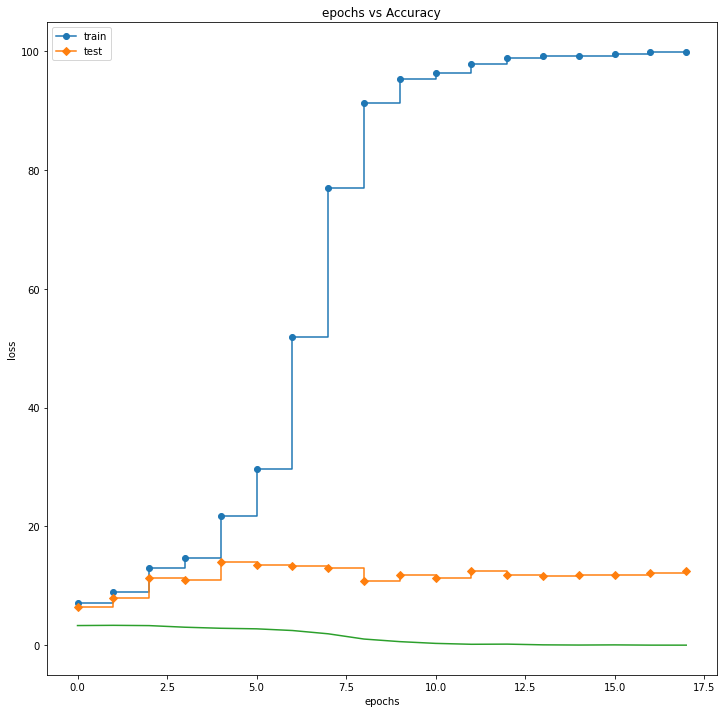

In [15]:
t1=time()
loss_vals, epoch_vals,train_accuracies,test_accuracies = train(train_dataloader,test_dataloader, model, loss_fn, optimizer, epochs=18)#epochs=15 fine
t=time()-t1
print('time',t)
#time calc
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlabel("epoch-")
ax.set_ylabel("Accuracy")
ax.set_title("epochs vs Accuracy")
ax.plot(epoch_vals, train_accuracies, marker="o", label="train", drawstyle="steps-post")
ax.plot(epoch_vals, test_accuracies, marker="D", label="test", drawstyle="steps-post")
ax.legend()
# pt.show()
fig.savefig('epoch_vs_accuracy.png')
# plt.plot(epoch_vals, accuracy_vals)
# plt.savefig('epoch_vs_accuracy.png')  

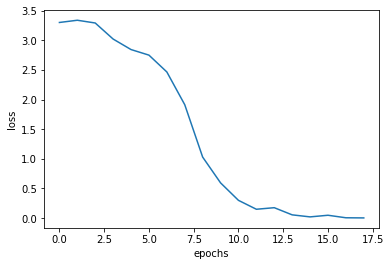

In [16]:
plt.xlabel('epochs')
plt.ylabel('loss')    
plt.plot(epoch_vals, loss_vals)
plt.savefig('epoch_vs_loss_vals.png')

In [20]:
print('convergence_epsilon',abs(loss_vals[-1]-loss_vals[-2]))#2e-3

convergence_epsilon 0.0024321097880601883


In [18]:
print(epoch_vals)
print(loss_vals)
print(train_accuracies)
print(test_accuracies)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[3.3012826442718506, 3.338911771774292, 3.2924740314483643, 3.021477460861206, 2.8440041542053223, 2.7500696182250977, 2.465944766998291, 1.91327702999115, 1.0292397737503052, 0.593842625617981, 0.2986454665660858, 0.14824791252613068, 0.1745837926864624, 0.05374796316027641, 0.019448822364211082, 0.04697462171316147, 0.0044742668978869915, 0.002042157109826803]
[7.099415204678363, 8.97076023391813, 12.99122807017544, 14.739766081871345, 21.739766081871345, 29.66374269005848, 51.87426900584795, 76.91520467836257, 91.31871345029239, 95.38888888888889, 96.33625730994152, 97.88888888888889, 98.7748538011696, 99.12573099415205, 99.18713450292398, 99.60526315789474, 99.8421052631579, 99.82456140350877]
[6.508771929824561, 7.859649122807018, 11.280701754385964, 10.912280701754385, 13.94736842105263, 13.456140350877194, 13.368421052631579, 13.052631578947368, 10.807017543859649, 11.771929824561402, 11.280701754385964, 12.473684210

In [21]:
import torchvision.models as models
# mdl = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')
#best model 

plot train acc also ,to get training idea,model strength